In [23]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import timedelta

In [24]:
import numpy as np
import pandas as pd

In [25]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [26]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [27]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [28]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [29]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [30]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

In [32]:
# Review Measurement Table
engine.execute('SELECT * FROM  Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [33]:
# Review Station Table
engine.execute('SELECT * FROM  Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

# Exploratory Climate Analysis

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Determine the last date
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Convert last_date from string to date
last_date=dt.datetime.strptime(last_date, "%Y-%m-%d")
last_date

datetime.datetime(2017, 8, 23, 0, 0)

In [39]:
# Calculate the date 1 year ago from the last data point in the database
first_date = last_date - timedelta(days=365)
first_date

datetime.datetime(2016, 8, 23, 0, 0)

In [72]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= first_date).all()
precip_data

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data).set_index('date')

# Rename the prcp column
precip_df.rename(columns = {'prcp':'Precipitation'}, inplace = True)
precip_df

,Precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [52]:
# Sort the dataframe by date
precip_df=precip_df.sort_values(by='date').dropna()
precip_df.head()

,Precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45


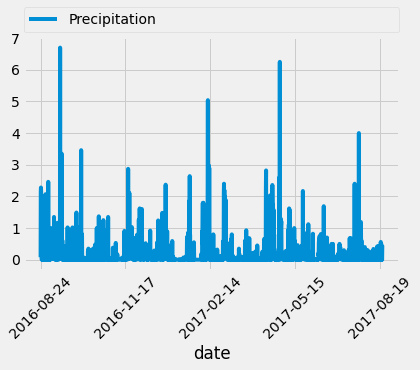

In [58]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=45)
plt.savefig("Precipitation analysis.jpg", bbox_inches="tight")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower right',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [59]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [62]:
# Design a query to show how many stations are available in this dataset?
n_stations = session.query(func.count(Station.station)).all()
n_stations

[(9)]

In [71]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_n_obs = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
stations_n_obs

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [70]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station_x = 'USC00519281'
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs),
              func.avg(Measurement.tobs)).filter(Measurement.station == station_x).all()

[(54.0, 85.0, 71.66378066378067)]

In [78]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 
station_x_obs = session.query(Measurement.tobs).filter(Measurement.station ==\
station_x).filter(Measurement.date >= first_date).all()

station_x_df = pd.DataFrame(station_x_obs, columns =['tobs'])
station_x_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


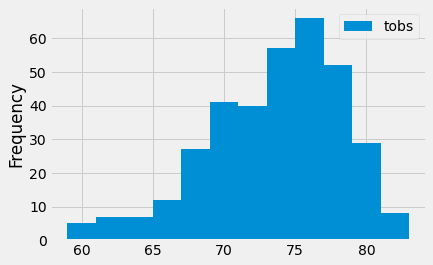

In [81]:
# ...and plot the results as a histogram
station_x_df.plot.hist(bins=12)
plt.savefig("Frequency analysis.jpg", bbox_inches="tight")

## Bonus Challenge Assignment

In [85]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [93]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
d1_of_vac = ('2017-02-28')
d7_of_vac = ('2017-02-28')

vac_temps = calc_temps(d1_of_vac, d7_of_vac)
vac_temps

[(69.0, 72.28571428571429, 74.0)]

In [94]:
#Create the df
vac_temps_df = pd.DataFrame(vac_temps, columns=["t_min", "t_avg", "t_max"])

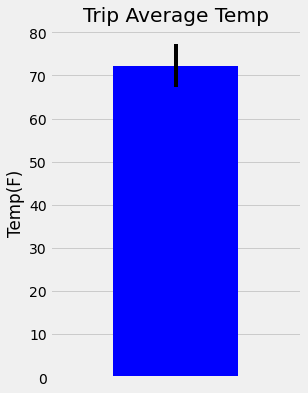

<Figure size 432x288 with 0 Axes>

In [99]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(4,6))
ax=vac_temps_df["t_avg"].plot.bar(yerr=(vac_temps_df["t_max"]-vac_temps_df["t_min"]), 
                                  color="blue")
plt.title("Trip Average Temp")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()


# Save the plot
plt.savefig("Trip Avg Temp.jpg", bbox_inches="tight")

In [100]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain = [func.count(Measurement.prcp),Measurement.station, Station.name,\
       Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*rain).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= d1_of_vac).filter(Measurement.date <= d7_of_vac).\
    order_by(func.count(Measurement.prcp).desc()).all()
for x in rainfall:
    print(x)

(1, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(1, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(1, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
(1, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(1, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(0, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
